# **Multivariable Linear Regression with multiple methods**

## **Getting Data from Google spreadsheet:**

In [2]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1kvyMOd14mohMHRAfs8mgjKKoi7sAu-Av3SgPYicrOh4/edit#gid=1171598407')

In [5]:
# Data 1
sheet1=wb.worksheet('Data1')
data1=sheet1.get_all_values()
df1=pd.DataFrame(data1)
df1.columns=df1.iloc[0]
df1=df1.iloc[1:]

In [6]:
# Data 2
sheet2=wb.worksheet('Data2')
data2=sheet2.get_all_values()
df2=pd.DataFrame(data2)
df2.columns=df2.iloc[0]
df2=df2.iloc[1:]

In [7]:
# Data 3
sheet3=wb.worksheet('Data3')
data3=sheet3.get_all_values()
df3=pd.DataFrame(data3)
df3.columns=df3.iloc[0]
df3=df3.iloc[1:]

In [8]:
# Data 4
sheet4=wb.worksheet('Data4')
data4=sheet4.get_all_values()
df4=pd.DataFrame(data4)
df4.columns=df4.iloc[0]
df4=df4.iloc[1:]

### **Linear Regression from scratch by Numerical and Gradient Descent method**

In [104]:
import matplotlib.pyplot as plt

class Linear_Regression:
    def __init__(self, df, x_cols, y_col, relationship='linear'):
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        self.relationship = relationship
        self.X = self.prepare_X()
        self.y_list = self.prepare_y()
        self.params = [[0] for _ in range(len(self.X[0]))]

    def prepare_X(self):
        X = []
        for col in self.x_cols:
            X.append([float(item) for item in list(self.df[col])])
        ones = [1 for _ in range(len(X[0]))]
        X = [list(item) for item in zip(ones, *X)]
        return X

    def prepare_y(self):
        if self.relationship == 'linear':
            return [[float(item)] for item in list(self.df[self.y_col])]
        elif self.relationship == 'exponential':
            return [[np.log(float(item))] for item in list(self.df[self.y_col])]

    def plot_scatter(self):
        # Flatten the y_list
        y = [item for sublist in self.y_list for item in sublist]
        # Transpose X
        X_transpose = self.transpose(self.X)

        for i, x in enumerate(X_transpose[1:]):  # Skip the first column of ones
            plt.figure(i)
            plt.scatter(x, y, s=0.4)
            plt.title(f'Scatter plot of {self.x_cols[i]} vs {self.y_col}')
            plt.xlabel(self.x_cols[i])
            plt.ylabel(self.y_col)
            plt.tick_params(left = False, bottom = False)
            plt.show()


    def transpose(self, matrix):
      return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]


    def matrix_multiplication(self, A, B):
      rows_A = len(A)
      cols_A = len(A[0])
      rows_B = len(B)
      cols_B = len(B[0])
      # print(rows_A, cols_A, rows_B, cols_B)
      if cols_A != rows_B:
          print("Incompatible matrices. Can't perform multiplication.")
          return

      # Create result matrix and fill with zeros
      C = [[0 for row in range(cols_B)] for col in range(rows_A)]

      for i in range(rows_A):
          for j in range(cols_B):
              for k in range(rows_B):
                  C[i][j] += A[i][k] * B[k][j]
      return C

    #############---------------------Inverse by using Gauss Elimination method--------------------------------###############

    def gaussian_elimination_inverse(self, A):
      n = len(A)
      # Augment A with I
      AI = [[0 for _ in range(2*n)] for _ in range(n)]
      for i in range(n):
          for j in range(n):
              AI[i][j] = A[i][j]
              AI[i][j+n] = 1 if i == j else 0

      for i in range(n):
          # Search for maximum in this column
          maxEl = abs(AI[i][i])
          maxRow = i
          for k in range(i+1, n):
              if abs(AI[k][i]) > maxEl:
                  maxEl = abs(AI[k][i])
                  maxRow = k

          # Swap maximum row with current row
          AI[maxRow], AI[i] = AI[i], AI[maxRow]

          # Make all rows below this one 0 in current column
          for k in range(i+1, n):
              c = -AI[k][i]/AI[i][i]
              for j in range(i, 2*n):
                  if i == j:
                      AI[k][j] = 0
                  else:
                      AI[k][j] += c * AI[i][j]

      # Check for singularity
      for i in range(n):
          if AI[i][i] == 0:
              return "The matrix is singular, so the inverse does not exist."

      # Back substitution
      for i in range(n-1, -1, -1):
          for k in range(i-1, -1, -1):
              c = -AI[k][i]/AI[i][i]
              for j in range(2*n):
                  if j != i:
                      AI[k][j] += c * AI[i][j]
          # Normalize row i
          AI[i] = [a/AI[i][i] for a in AI[i]]

      # Extract inverse matrix
      A_inv = [[AI[i][j+n] for j in range(n)] for i in range(n)]
      return A_inv

    def predict_y(self):
        X_T = self.transpose(self.X)
        X_TX = self.matrix_multiplication(X_T, self.X)
        X_TX_inv = self.gaussian_elimination_inverse(X_TX)
        X_TY = self.matrix_multiplication(X_T, self.y_list)
        M = self.matrix_multiplication(X_TX_inv, X_TY)
        print("\n Cost Function by numerical method:", M)

        return self.matrix_multiplication(self.X, M)

    def error_calculate(self):
        # Flatten the lists
        y_predicted = [item for sublist in self.predict_y() for item in sublist]
        y_list = [item for sublist in self.y_list for item in sublist]

        # Calculate MSE
        mse = sum((p - a) ** 2 for p, a in zip(y_predicted, y_list)) / len(y_predicted)

        # Calculate RMSE
        rmse = mse ** 0.5

        # Calculate R-squared
        y_mean = sum(y_list) / len(y_list)
        ss_total = sum((a - y_mean) ** 2 for a in y_list)
        ss_residual = sum((p - a) ** 2 for p, a in zip(y_predicted, y_list))
        r2 = 1 - (ss_residual / ss_total)

        print("\n Error by scratch method:")
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("R-squared:", r2)

    #####------------------------------------Finding Cost using Gradient Descent-------------------------------------------#########

    def gradient_descent(self):
        m = len(self.y_list)
        for i in range(self.iterations):
            h = self.matrix_multiplication(self.X, self.params)
            error = [[h[j][0] - self.y_list[j][0]] for j in range(m)]
            gradient = self.matrix_multiplication(self.transpose(self.X), error)
            self.params = [[self.params[j][0] - (self.learning_rate/m) * gradient[j][0]] for j in range(len(self.params))]
        print("\n Cost by gradient method: ", self.params)

    def train(self, iteration, learning_rate):
        self.learning_rate = learning_rate
        self.iterations = iteration
        return self.gradient_descent()

    def scikit_learn(self):
      from sklearn.linear_model import LinearRegression
      from sklearn.metrics import mean_squared_error, r2_score
      import numpy as np

      # Create a Linear Regression object
      lr = LinearRegression()

      # Fit the model to the data
      lr.fit(self.X, self.y_list)

      # Make predictions on the same data
      y_pred = lr.predict(self.X)
      print("\n Error by scikit method:")
      # Calculate the mean squared error of the predictions
      mse = mean_squared_error(self.y_list, y_pred)
      print(f"Mean Squared Error: {mse}")

      # Calculate the coefficient of determination (R^2 score)
      r2 = r2_score(self.y_list, y_pred)
      print(f"R^2 Score: {r2}")




### **Using Method on different datasets:**

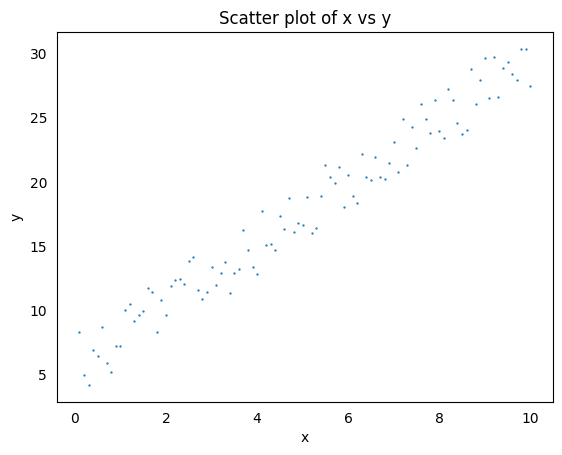


 Cost Function by numerical method: [[5.6807871267612455], [2.384060066057181]]

 Error by scratch method:
MSE: 2.0785254017773274
RMSE: 1.4417091945941551
R-squared: 0.9579571905586357

 Cost by gradient method:  [[5.680758659438731], [2.3840643453748847]]

 Error by scikit method:
Mean Squared Error: 2.0785254017773274
R^2 Score: 0.9579571905586357


In [98]:
# Data 1

data_prep = Linear_Regression(df1, ['x'], 'y')
data_prep.plot_scatter()
data_prep.error_calculate()
data_prep.train(1000, 0.05)
data_prep.scikit_learn()

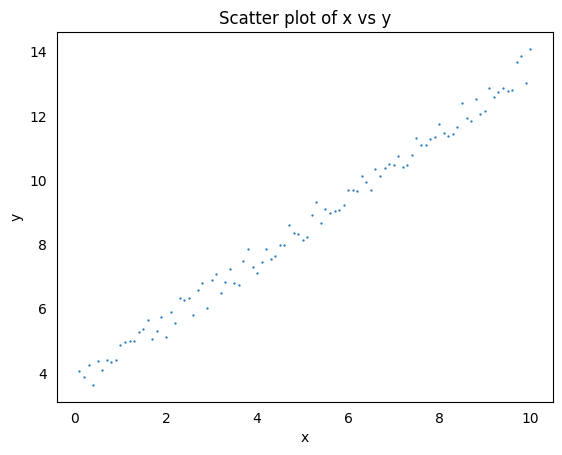


 Cost Function by numerical method: [[3.682122666293189], [0.9729974518460569]]

 Error by scratch method:
MSE: 0.07643342704351971
RMSE: 0.27646596000867757
R-squared: 0.9904038522690993

 Cost by gradient method:  [[3.6821037544687716], [0.9730002947444361]]

 Error by scikit method:
Mean Squared Error: 0.07643342704351971
R^2 Score: 0.9904038522690993


In [105]:
# Data 2

data_prep = Linear_Regression(df2, ['x'], 'y', relationship='exponential')
data_prep.plot_scatter()
data_prep.error_calculate()
data_prep.train(1000, 0.05)
data_prep.scikit_learn()

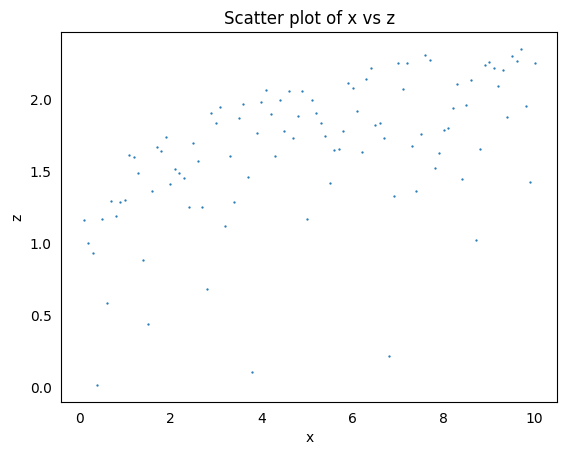


 Cost Function by numerical method: [[1.1770620783119963], [0.09419021414817919]]

 Error by scratch method:
MSE: 0.16173044143088552
RMSE: 0.4021572347116057
R-squared: 0.31369732267280803

 Cost by gradient method:  [[1.1770558584302782], [0.09419114914478582]]

 Error by scikit method:
Mean Squared Error: 0.16173044143088552
R^2 Score: 0.3136973226728079


In [100]:
# Data 3

data_prep = Linear_Regression(df3, ['x'], 'z')
data_prep.plot_scatter()
data_prep.error_calculate()
data_prep.train(1000, 0.05)
data_prep.scikit_learn()

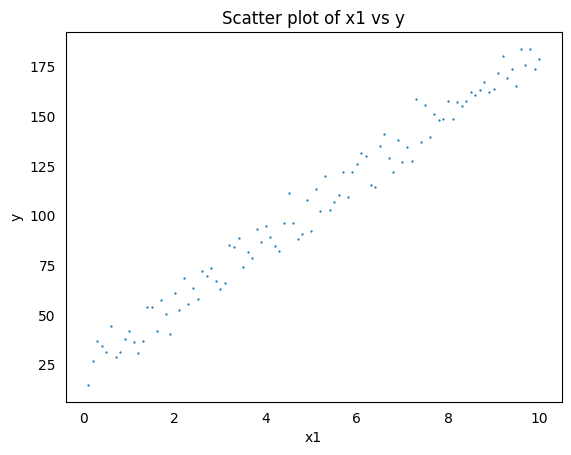

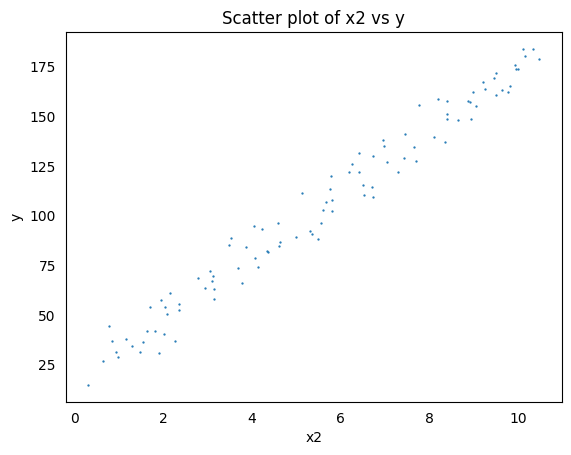

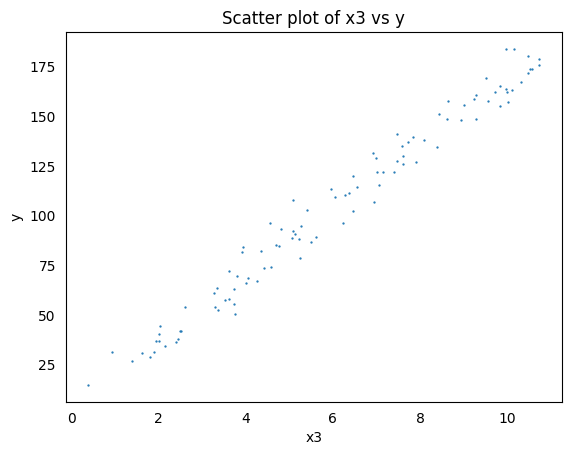


 Cost Function by numerical method: [[13.239477824421101], [6.132437632710662], [2.3922655421880563], [7.746810379932413]]

 Error by scratch method:
MSE: 34.620480829243554
RMSE: 5.883917133104744
R-squared: 0.9841749058943147

 Cost by gradient method:  [[13.239475793250877], [6.132434333809515], [2.3922682969119413], [7.746810935958502]]

 Error by scikit method:
Mean Squared Error: 34.62048082924354
R^2 Score: 0.9841749058943147


In [101]:
# Data 4

data_prep = Linear_Regression(df4, ['x1', 'x2', 'x3'], 'y')
data_prep.plot_scatter()
data_prep.error_calculate()
data_prep.train(100000, 0.005)
data_prep.scikit_learn()

### **Linear Regression: Numerical and Gradient Descent methods by using numpy**

In [47]:
import numpy as np

class LR_using_numpy:
    def __init__(self, df, x_cols, y_col, relationship='linear'):
        self.df = df
        self.x_cols = x_cols
        self.y_col = y_col
        self.relationship = relationship
        self.X = self.prepare_X()
        self.y_list = self.prepare_y()
        self.params = [[0] for _ in range(len(self.X[0]))]

    def prepare_X(self):
        X = []
        for col in self.x_cols:
            X.append([float(item) for item in list(self.df[col])])
        ones = np.ones((len(X[0]), 1))
        X = np.hstack((ones, np.array(X).T))
        return X

    def prepare_y(self):
        if self.relationship == 'linear':
            return np.array([[float(item)] for item in list(self.df[self.y_col])])
        elif self.relationship == 'exponential':
            return np.log(np.array([[float(item)] for item in list(self.df[self.y_col])]))


    def normal_equation(self):
        # Calculate X transpose
        X_T = self.X.T

        # Calculate X transpose times X
        X_T_X = X_T.dot(self.X)

        # Calculate the inverse of X transpose times X
        inv_X_T_X = np.linalg.inv(X_T_X)

        # Calculate X transpose times Y
        X_T_Y = X_T.dot(self.y_list)

        # Calculate the coefficients (M)
        M = inv_X_T_X.dot(X_T_Y)
        print("\n Cost by numerical method: ", M)

    def gradient_descent(self):
        m = len(self.y_list)

        for i in range(self.iterations):
            self.params = self.params - (self.learning_rate/m) * (np.transpose(self.X) @ (self.X @ self.params - self.y_list))
        print("\n Cost by gradient method: ", self.params)

    def train(self, iteration, learning_rate):
        self.learning_rate = learning_rate
        self.iterations = iteration
        return self.gradient_descent()



### **Method used for different dataset:**

In [48]:
data_prep = LR_using_numpy(df1, ['x'], 'y')
data_prep.normal_equation()
data_prep.train(1000, 0.05)


 Cost by numerical method:  [[5.68078713]
 [2.38406007]]

 Cost by gradient method:  [[5.68075866]
 [2.38406435]]


In [44]:
data_prep = LR_using_numpy(df2, ['x'], 'y', relationship='exponential')
data_prep.normal_equation()
data_prep.train(1000, 0.05)


 Cost by numerical method:  [[3.68212267]
 [0.97299745]]

 Cost by gradient method:  [[3.68210375]
 [0.97300029]]


In [45]:
data_prep = LR_using_numpy(df3, ['x'], 'z')
data_prep.normal_equation()
data_prep.train(1000, 0.05)


 Cost by numerical method:  [[1.17706208]
 [0.09419021]]

 Cost by gradient method:  [[1.17705586]
 [0.09419115]]


In [46]:
data_prep = LR_using_numpy(df4, ['x1', 'x2', 'x3'], 'y')
data_prep.normal_equation()
data_prep.train(100000, 0.005)


 Cost by numerical method:  [[13.23947782]
 [ 6.13243763]
 [ 2.39226554]
 [ 7.74681038]]

 Cost by gradient method:  [[13.23947579]
 [ 6.13243433]
 [ 2.3922683 ]
 [ 7.74681094]]
